# Generative Adversarial Networks

## Construindo uma Rede Neural que aprende a gerar dígitos manuscritos

## Introdução

De acordo com Yann LeCun, "Adversarial training is the coolest thing since sliced bread.". O pão cortado certamente nunca criou essa excitação dentro da comunidade de aprendizado profundo. As redes adversárias generativas - ou os GANs - afiaram dramaticamente a possibilidade de conteúdo gerado por IA e desencadearam esforços de pesquisa ativos desde que foram descitos por [Ian Goodfellow et al. in 2014](https://arxiv.org/abs/1406.2661). Os GANs são redes neurais que aprendem a criar dados sintéticos semelhantes a alguns dados de entrada conhecidos.

## Arquitetura GAN

Generative adversarial networks consistem de 2 modelos: modelo generativo e modelo discriminativo.

![caption](images/GAN_Overall.png)

O modelo discriminativo é um classificador que determina se uma determinada imagem se parece com uma imagem real do conjunto de dados ou como uma imagem criada artificialmente. Este é basicamente um classificador binário que assumirá a forma de uma rede neural convolucional normal (CNN).

O modelo generativo possui valores de entrada aleatórios e os transforma em imagens através de uma rede neural deconvolucional.

Ao longo de muitas iterações de treinamento, os pesos e os bias nos modelos discriminativo e o generativo são treinados através de backpropagation. O modelo discriminativo aprende a identificar imagens "reais" de dígitos manuscritos além das imagens "falsas" criadas pelo modelo generativo. Ao mesmo tempo, o modelo generativo usa as perdas do modelo discriminativo para aprender a produzir imagens convincentes que o modelo discriminativo não consegue mais distinguir de imagens reais.

In [1]:
# Importando as bibliotecas necessárias
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers


## Carregando o Dataset

11490434/11490434 [==============================] - 0s 0us/step
(28, 28)


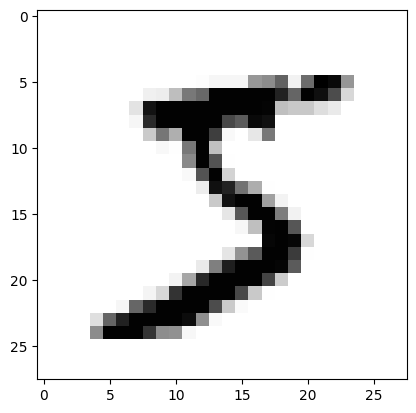

In [2]:
# Carregar o conjunto de dados MNIST
(x_train, _), (_, _) = keras.datasets.mnist.load_data()

# Normalizar os dados
x_train = x_train.astype("float32") / 255.0

# Definir a dimensão do ruído de entrada
latent_dim = 128

sample_image = x_train[0]
print(sample_image.shape)

sample_image = sample_image.reshape([28, 28])
plt.imshow(sample_image, cmap='Greys')

## Discriminator Network

O discriminador é uma rede neural convolucional (CNN) que tem a tarefa de distinguir entre imagens reais e imagens geradas pelo gerador. Ele recebe uma imagem como entrada e produz uma única saída, que representa a probabilidade de a imagem ser real.

Nosso modelo discriminativo é uma rede neural convolucional que recebe uma imagem de tamanho 28 x 28 x 1 como entrada e retorna um único número escalar que descreve se a imagem de entrada é ou não "real" ou "falsa" - ou seja, seja desenhada do conjunto de imagens MNIST ou geradas pelo modelo generativo.

![caption](images/GAN_Discriminator.png)

* A entrada para o discriminador é uma imagem do MNIST com dimensões 28x28 pixels e um único canal de cor (escala de cinza).

* A primeira camada do discriminador é uma camada convolucional Conv2D com 64 filtros, um tamanho de kernel de 3x3 e um stride (passo) de 2. Isso reduz as dimensões da imagem pela metade e aumenta o número de filtros. A função de ativação usada é a LeakyReLU, que ajuda a evitar o problema do gradiente zero.

* Em seguida, temos outra camada Conv2D com 128 filtros, um tamanho de kernel de 3x3 e um stride de 2. Novamente, a função de ativação LeakyReLU é aplicada após a camada convolucional.

* Após as camadas convolucionais, temos uma camada Flatten que transforma o tensor de saída em um vetor unidimensional, para ser usado como entrada em uma rede neural densa (totalmente conectada).

* A camada seguinte é uma camada Dropout com uma taxa de dropout de 0,4. Isso ajuda a evitar o overfitting, desligando aleatoriamente alguns neurônios durante o treinamento.

* Por fim, temos uma camada Dense com um único neurônio e função de ativação sigmoid. Essa camada produz uma saída entre 0 e 1, representando a probabilidade de a imagem ser real. Valores próximos de 0 indicam alta probabilidade de a imagem ser falsa, enquanto valores próximos de 1 indicam alta probabilidade de a imagem ser real.


In [3]:
# Criar o discriminador
discriminator = keras.Sequential([
    keras.Input(shape=(28, 28, 1)),
    layers.Conv2D(64, kernel_size=3, strides=2, padding="same"),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2D(128, kernel_size=3, strides=2, padding="same"),
    layers.LeakyReLU(alpha=0.2),
    layers.Flatten(),
    layers.Dropout(0.4),
    layers.Dense(1, activation="sigmoid")
])

# Compilar o discriminador
discriminator.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    loss=keras.losses.BinaryCrossentropy(),
)

# Congelar o discriminador durante o treinamento do gerador
discriminator.trainable = False

## Generator Network

![caption](images/GAN_Generator.png)

Agora que temos o nosso modelo discriminativo definido, vamos dar uma olhada no modelo generativo. O gerador é responsável por criar imagens sintéticas a partir de ruído latente como entrada. Ele recebe um vetor de ruído como entrada e produz uma imagem sintética como saída.

A estrutura do gerador é projetada para transformar o ruído latente em uma representação cada vez mais próxima de uma imagem sintética realista. Através do treinamento adversarial com o discriminador, o gerador aprende a criar imagens que enganam o discriminador, parecendo cada vez mais reais.

* A entrada do gerador é um vetor de ruído latente com dimensão latent_dim. Esse vetor de ruído é usado para gerar uma imagem sintética.

* A primeira camada do gerador é uma camada densa (Dense) que mapeia o vetor de ruído latente para um tensor de maior dimensão. O número de unidades nessa camada (7 * 7 * 128) é calculado para que, após a operação Reshape, o tensor tenha dimensões (7, 7, 128).

* Em seguida, temos uma camada de redimensionamento (Reshape) que transforma o tensor em uma forma tridimensional, permitindo a entrada em uma camada convolucional transposta.

* A camada convolucional transposta (Conv2DTranspose) é usada para aumentar as dimensões espaciais da imagem sintética. Ela usa filtros de convolução para realizar a operação de transposição, aumentando o tamanho da imagem. Essa camada é seguida por uma camada de normalização de lote (BatchNormalization) para normalizar os valores do tensor e melhorar a estabilidade e a capacidade de generalização do modelo.

* Após a normalização de lote, usamos a função de ativação LeakyReLU para introduzir não-linearidade na rede e evitar problemas de gradientes desvanecidos.

* Em seguida, temos outra camada convolucional transposta que aumenta ainda mais as dimensões espaciais da imagem.

* Finalmente, a última camada do gerador é uma camada convolucional transposta com um único filtro, um tamanho de kernel de 7x7 e uma função de ativação sigmoid. Essa camada produz a imagem sintética de saída, com valores de pixel normalizados entre 0 e 1.

In [4]:
# Criar o gerador
generator = keras.Sequential([
    keras.Input(shape=(latent_dim,)),
    layers.Dense(7 * 7 * 128),
    layers.Reshape((7, 7, 128)),
    layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
    layers.BatchNormalization(momentum=0.8),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
    layers.BatchNormalization(momentum=0.8),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2DTranspose(1, kernel_size=7, strides=1, padding="same", activation="sigmoid")
])

# Construindo a GAN

In [5]:
# Construindo a GAN combinando o gerador e o discriminador
gan = keras.Sequential([generator, discriminator])
gan.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    loss=keras.losses.BinaryCrossentropy(),
)

In [6]:
# Função para amostrar um conjunto de ruído
def generate_latent_noise(batch_size):
    return np.random.normal(0, 1, (batch_size, latent_dim))

## Treinando o Modelo GAN

Uma das partes mais complicadas sobre a criação e ajuste de GANs é que eles têm duas funções de perda: uma que incentiva o gerador a criar imagens melhores e a outra que encoraja o discriminador a distinguir imagens geradas de imagens reais.

Treinamos tanto o gerador quanto o discriminador simultaneamente. À medida que o discriminador melhora em distinguir imagens reais de imagens geradas, o gerador é capaz de melhor ajustar seus pesos e distorções para gerar imagens convincentes.

2/2 [==============================] - 3s 3ms/step
Epoch 0/4000 - Disc Loss: 0.6906366944313049 - Gen Loss: 0.7240773439407349
1/1 [==============================] - 0s 378ms/step


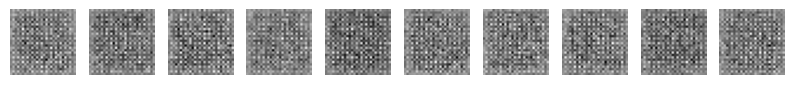

2/2 [==============================] - 0s 5ms/step
Epoch 100/4000 - Disc Loss: 0.8326673805713654 - Gen Loss: 0.8105699419975281
1/1 [==============================] - 0s 17ms/step


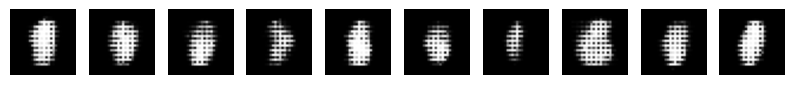

2/2 [==============================] - 0s 8ms/step
Epoch 200/4000 - Disc Loss: 0.7364146411418915 - Gen Loss: 0.6680194139480591
1/1 [==============================] - 0s 16ms/step


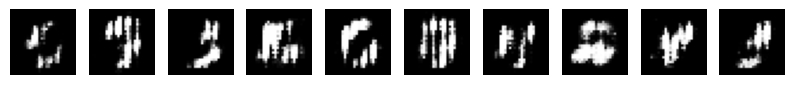

2/2 [==============================] - 0s 6ms/step
Epoch 300/4000 - Disc Loss: 0.7091267108917236 - Gen Loss: 0.7262474298477173
1/1 [==============================] - 0s 18ms/step


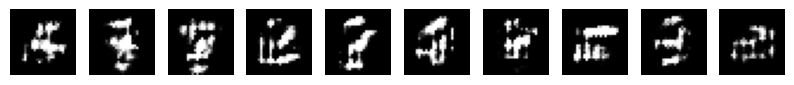

2/2 [==============================] - 0s 5ms/step
Epoch 400/4000 - Disc Loss: 0.7092788815498352 - Gen Loss: 0.7019078731536865
1/1 [==============================] - 0s 16ms/step


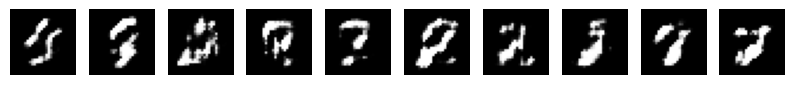

2/2 [==============================] - 0s 6ms/step
Epoch 500/4000 - Disc Loss: 0.7064062356948853 - Gen Loss: 0.7198948860168457
1/1 [==============================] - 0s 16ms/step


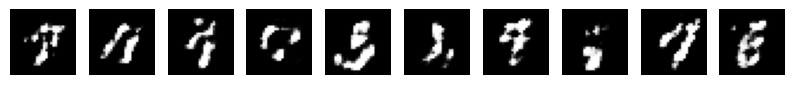

2/2 [==============================] - 0s 5ms/step
Epoch 600/4000 - Disc Loss: 0.7048740386962891 - Gen Loss: 0.6967355608940125
1/1 [==============================] - 0s 17ms/step


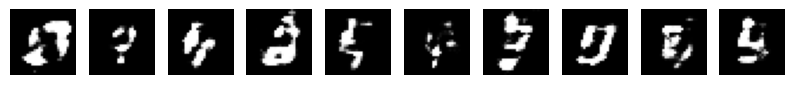

2/2 [==============================] - 0s 8ms/step
Epoch 700/4000 - Disc Loss: 0.7071792483329773 - Gen Loss: 0.6905341148376465
1/1 [==============================] - 0s 16ms/step


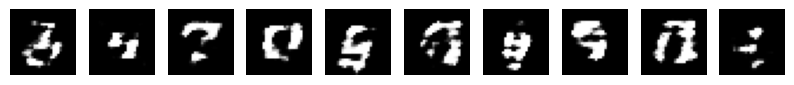

2/2 [==============================] - 0s 6ms/step
Epoch 800/4000 - Disc Loss: 0.7079936265945435 - Gen Loss: 0.7184408903121948
1/1 [==============================] - 0s 17ms/step


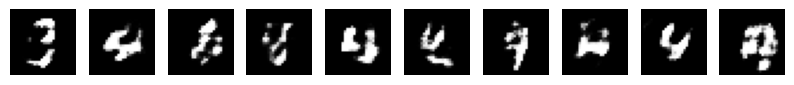

2/2 [==============================] - 0s 7ms/step
Epoch 900/4000 - Disc Loss: 0.699928343296051 - Gen Loss: 0.7122117877006531
1/1 [==============================] - 0s 17ms/step


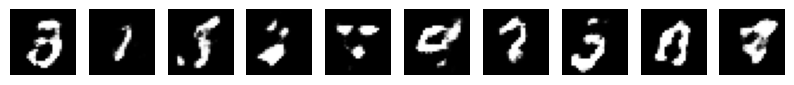

2/2 [==============================] - 0s 7ms/step
Epoch 1000/4000 - Disc Loss: 0.6905085146427155 - Gen Loss: 0.6977163553237915
1/1 [==============================] - 0s 17ms/step


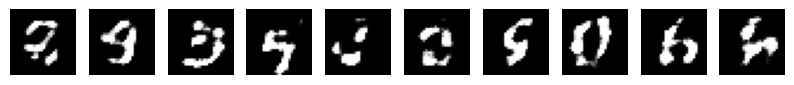

2/2 [==============================] - 0s 6ms/step
Epoch 1100/4000 - Disc Loss: 0.6901002526283264 - Gen Loss: 0.6851326823234558
1/1 [==============================] - 0s 18ms/step


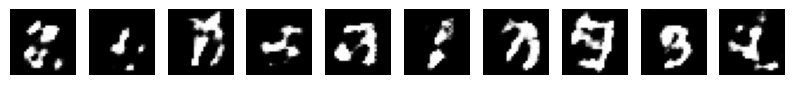

2/2 [==============================] - 0s 6ms/step
Epoch 1200/4000 - Disc Loss: 0.6930201351642609 - Gen Loss: 0.7075591683387756
1/1 [==============================] - 0s 20ms/step


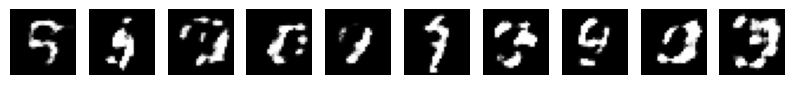

2/2 [==============================] - 0s 8ms/step
Epoch 1300/4000 - Disc Loss: 0.6934429407119751 - Gen Loss: 0.7229971885681152
1/1 [==============================] - 0s 20ms/step


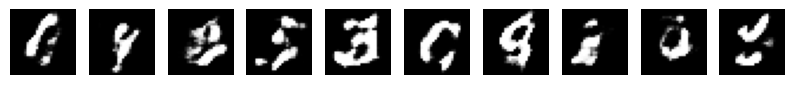

2/2 [==============================] - 0s 8ms/step
Epoch 1400/4000 - Disc Loss: 0.6947443783283234 - Gen Loss: 0.692805290222168
1/1 [==============================] - 0s 17ms/step


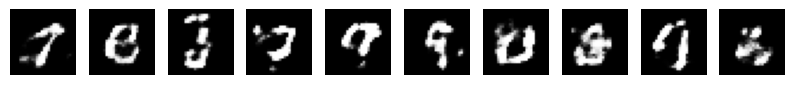

2/2 [==============================] - 0s 6ms/step
Epoch 1500/4000 - Disc Loss: 0.683861494064331 - Gen Loss: 0.6868839263916016
1/1 [==============================] - 0s 20ms/step


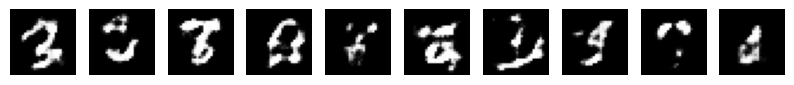

2/2 [==============================] - 0s 7ms/step
Epoch 1600/4000 - Disc Loss: 0.695833832025528 - Gen Loss: 0.6928615570068359
1/1 [==============================] - 0s 20ms/step


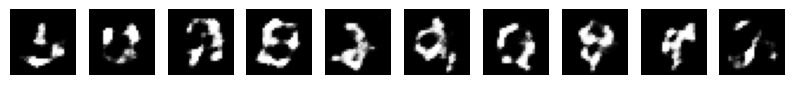

2/2 [==============================] - 0s 6ms/step
Epoch 1700/4000 - Disc Loss: 0.6904259920120239 - Gen Loss: 0.7017697095870972
1/1 [==============================] - 0s 17ms/step


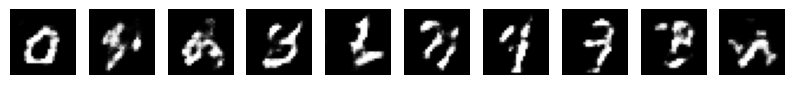

2/2 [==============================] - 0s 7ms/step
Epoch 1800/4000 - Disc Loss: 0.691658228635788 - Gen Loss: 0.7039656043052673
1/1 [==============================] - 0s 26ms/step


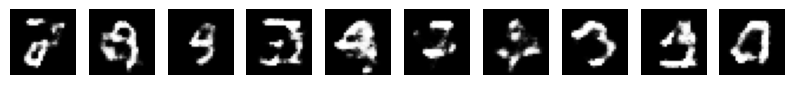

2/2 [==============================] - 0s 6ms/step
Epoch 1900/4000 - Disc Loss: 0.6897592544555664 - Gen Loss: 0.6976354122161865
1/1 [==============================] - 0s 18ms/step


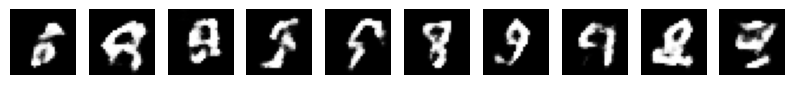

2/2 [==============================] - 0s 5ms/step
Epoch 2000/4000 - Disc Loss: 0.6957432627677917 - Gen Loss: 0.7143192291259766
1/1 [==============================] - 0s 17ms/step


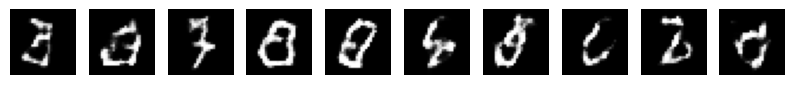

2/2 [==============================] - 0s 5ms/step
Epoch 2100/4000 - Disc Loss: 0.692631721496582 - Gen Loss: 0.6993576288223267
1/1 [==============================] - 0s 20ms/step


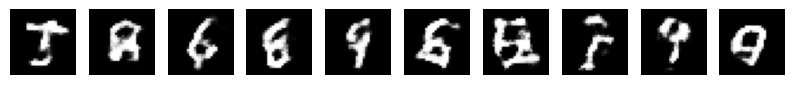

2/2 [==============================] - 0s 5ms/step
Epoch 2200/4000 - Disc Loss: 0.6915555894374847 - Gen Loss: 0.6989107131958008
1/1 [==============================] - 0s 20ms/step


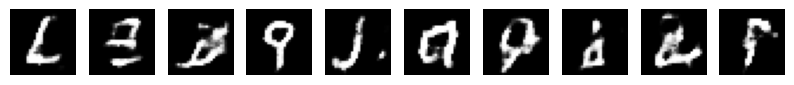

2/2 [==============================] - 0s 7ms/step
Epoch 2300/4000 - Disc Loss: 0.6951381862163544 - Gen Loss: 0.6992874145507812
1/1 [==============================] - 0s 16ms/step


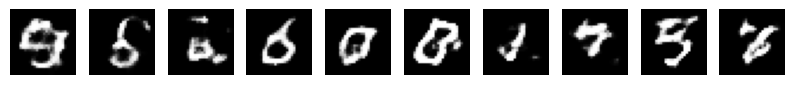

2/2 [==============================] - 0s 6ms/step
Epoch 2400/4000 - Disc Loss: 0.6944535374641418 - Gen Loss: 0.6968324184417725
1/1 [==============================] - 0s 18ms/step


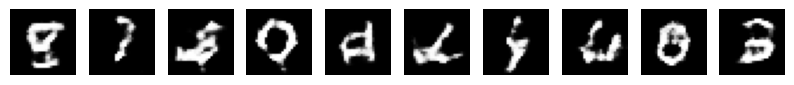

2/2 [==============================] - 0s 6ms/step
Epoch 2500/4000 - Disc Loss: 0.6920945346355438 - Gen Loss: 0.7062703371047974
1/1 [==============================] - 0s 17ms/step


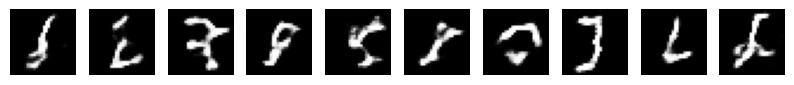

2/2 [==============================] - 0s 6ms/step
Epoch 2600/4000 - Disc Loss: 0.6960254907608032 - Gen Loss: 0.7053796052932739
1/1 [==============================] - 0s 16ms/step


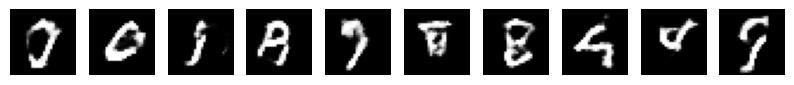

2/2 [==============================] - 0s 6ms/step
Epoch 2700/4000 - Disc Loss: 0.6909332871437073 - Gen Loss: 0.6961314678192139
1/1 [==============================] - 0s 16ms/step


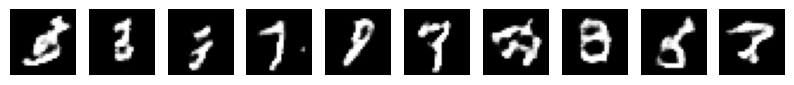

2/2 [==============================] - 0s 5ms/step
Epoch 2800/4000 - Disc Loss: 0.6949446201324463 - Gen Loss: 0.7010973691940308
1/1 [==============================] - 0s 17ms/step


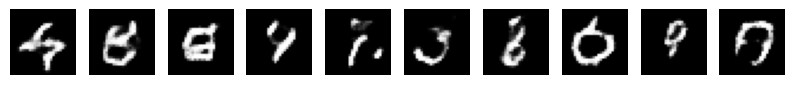

2/2 [==============================] - 0s 6ms/step
Epoch 2900/4000 - Disc Loss: 0.6935376822948456 - Gen Loss: 0.6936096549034119
1/1 [==============================] - 0s 17ms/step


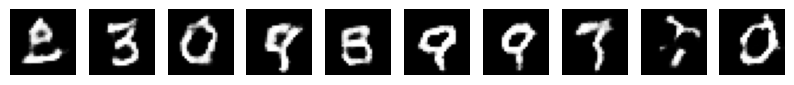

2/2 [==============================] - 0s 7ms/step
Epoch 3000/4000 - Disc Loss: 0.6953281462192535 - Gen Loss: 0.6959009766578674
1/1 [==============================] - 0s 17ms/step


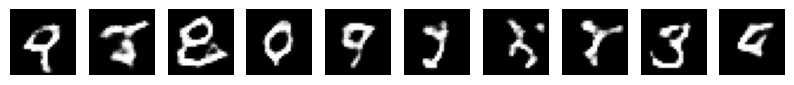

2/2 [==============================] - 0s 6ms/step
Epoch 3100/4000 - Disc Loss: 0.6921558976173401 - Gen Loss: 0.7087099552154541
1/1 [==============================] - 0s 17ms/step


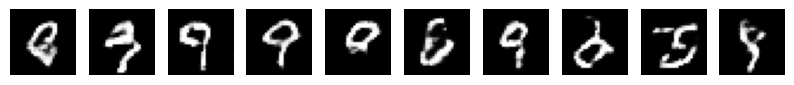

2/2 [==============================] - 0s 6ms/step
Epoch 3200/4000 - Disc Loss: 0.6942653656005859 - Gen Loss: 0.7002972364425659
1/1 [==============================] - 0s 16ms/step


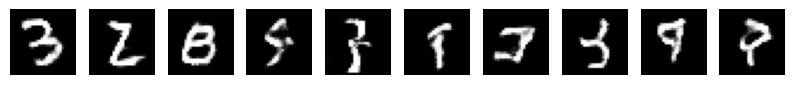

2/2 [==============================] - 0s 7ms/step
Epoch 3300/4000 - Disc Loss: 0.6954750418663025 - Gen Loss: 0.7013478875160217
1/1 [==============================] - 0s 19ms/step


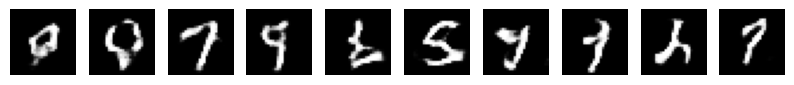

2/2 [==============================] - 0s 6ms/step
Epoch 3400/4000 - Disc Loss: 0.6917155981063843 - Gen Loss: 0.6947577595710754
1/1 [==============================] - 0s 17ms/step


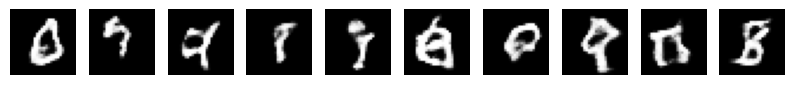

2/2 [==============================] - 0s 6ms/step
Epoch 3500/4000 - Disc Loss: 0.6942758560180664 - Gen Loss: 0.700224757194519
1/1 [==============================] - 0s 18ms/step


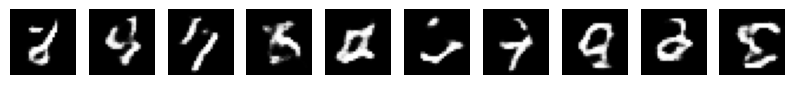

2/2 [==============================] - 0s 6ms/step
Epoch 3600/4000 - Disc Loss: 0.6928769648075104 - Gen Loss: 0.7020723819732666
1/1 [==============================] - 0s 18ms/step


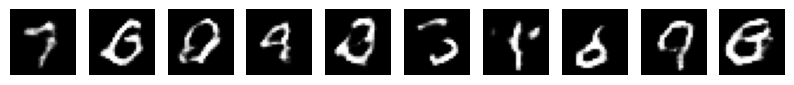

2/2 [==============================] - 0s 5ms/step
Epoch 3700/4000 - Disc Loss: 0.6929265856742859 - Gen Loss: 0.6977425217628479
1/1 [==============================] - 0s 17ms/step


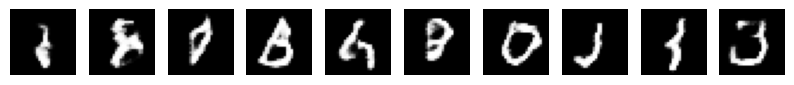

2/2 [==============================] - 0s 7ms/step
Epoch 3800/4000 - Disc Loss: 0.6913346350193024 - Gen Loss: 0.6976353526115417
1/1 [==============================] - 0s 18ms/step


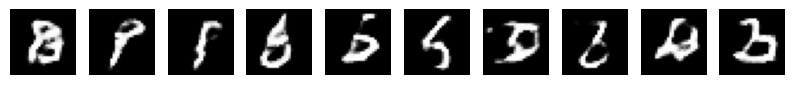

2/2 [==============================] - 0s 7ms/step
Epoch 3900/4000 - Disc Loss: 0.6953138709068298 - Gen Loss: 0.7003335356712341
1/1 [==============================] - 0s 16ms/step


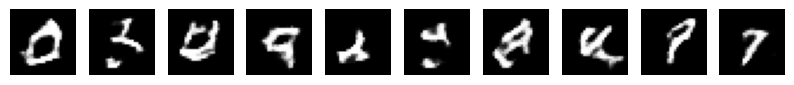

2/2 [==============================] - 0s 5ms/step


In [ ]:
# Parâmetros de treinamento
batch_size = 64
epochs = 4000
sample_interval = 100

# Treinamento da GAN
for epoch in range(epochs):
    # Treinamento do discriminador
    idx = np.random.randint(0, x_train.shape[0], batch_size)
    real_images = x_train[idx]
    real_labels = np.ones((batch_size, 1))

    noise = generate_latent_noise(batch_size)
    fake_images = generator.predict(noise)
    fake_labels = np.zeros((batch_size, 1))

    discriminator_loss_real = discriminator.train_on_batch(real_images, real_labels)
    discriminator_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
    discriminator_loss = 0.5 * np.add(discriminator_loss_real, discriminator_loss_fake)

    # Treinamento do gerador
    noise = generate_latent_noise(batch_size)
    generator_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

    # Mostrar o progresso a cada 100 iterações
    if epoch % sample_interval == 0:
        print(f"Epoch {epoch}/{epochs} - Disc Loss: {discriminator_loss} - Gen Loss: {generator_loss}")
        noise = generate_latent_noise(10)
        generated_images = generator.predict(noise)

        plt.figure(figsize=(10, 1))
        for i in range(10):
            plt.subplot(1, 10, i+1)
            plt.imshow(generated_images[i, :, :, 0], cmap="gray")
            plt.axis('off')
        plt.show()

In [ ]:
# Salvando o gerador treinado
generator.save('generator_model.h5')

1/1 [==============================] - 0s 93ms/step


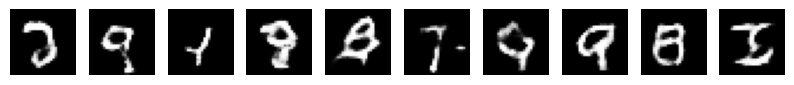

In [ ]:
from tensorflow import keras

# Carregar o modelo do gerador
generator = keras.models.load_model('generator_model.h5')

latent_dim = 128

# Função para gerar amostras de ruído latente
def generate_latent_noise(batch_size):
    return np.random.normal(0, 1, (batch_size, latent_dim))

# Gerar amostras sintéticas com o gerador carregado
num_samples = 10
noise = generate_latent_noise(num_samples)
generated_images = generator.predict(noise)

# Exibir as imagens geradas
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 1))
for i in range(num_samples):
    plt.subplot(1, num_samples, i+1)
    plt.imshow(generated_images[i, :, :, 0], cmap="gray")
    plt.axis('off')
plt.show()
